# STNCMG Tutorial

Taking slice 151675 of the human dorsolateral prefrontal cortex (DLPFC) as an example, we show the operation rules of STNCMG. The tissue section is divided into 7 areas, the data can be downloaded from https://research.libd.org/spatialLIBD/.

### Import python modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
from STNCMG import Mix_STNCMG
from Train import train_STNCMG
from Mix_adj import Transfer_pytorch_Data, Mix_adj, mclust_R

### Load data
When using other types of data, click on the link in the paper to download the data.

In [2]:
section_id = '151675'
print('Current slice %s'%(section_id))
input_dir = os.path.join('/home/szh/upload/DATA/DLPFC', section_id) 
adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

Current slice 151675


### Data preprocessing
We select the top 3000 highly variable genes (HVGs) as input and standardize them based on the library size. Subsequently, a natural logarithm transformation with base e is performed. However, as the mouse somatosensory cortex dataset contains only 33 genes, this dataset retains all the genes without any selection.

In [3]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Load ground truth data
The ground truth data for DLPFC data is under layer_guess in the metadata.tsv table.

In [4]:
df_meta = pd.read_csv(os.path.join('/home/szh/upload/DATA/DLPFC', section_id, 'metadata.tsv'), sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['Ground Truth'] = df_meta_layer.values

### Plot ground truth

[<Axes: title={'center': 'Ground Truth'}, xlabel='spatial1', ylabel='spatial2'>]

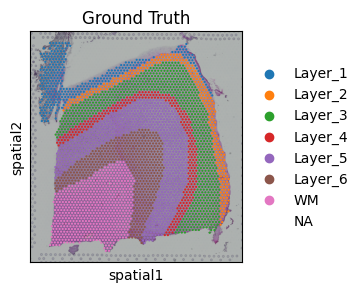

In [5]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"],show=False)

### Build the SNN diagram
In order to maximize the similarity of this adjacent point, two complementary methods are used in this study: K nearest neighbor (KNN) and R-radius method. KNN mainly selects Chebyshev's distance measurement method. KNN can better capture the local structure of the data. The R-radius is not limited to a fixed number of k nearest neighbors, and can adapt to data of different densities and distributions, helping to reveal the global structure of the data.

In [6]:
Mix_adj(adata, k_cutoff=6,rad_cutoff=150) 

The graph contains 21552 edges, 3592 cells.
6.0000 neighbors per cell on average.


### Training model

In [7]:
adata = train_STNCMG(adata,n_epochs=1000) 
print("Completion of training")
sc.pp.neighbors(adata, use_rep='STNCMG')
sc.tl.umap(adata)

Size of Input:  (3592, 3000)
Begin to train ST data...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [50:56<00:00,  3.06s/it]


Completion of training


### Start clustering
For data with a ground-truth, such as 10x Visium and osmFISH, we use the mclust method based on the Gaussian finite mixture model. 

In [8]:
adata = mclust_R(adata, num_cluster=7,used_obsm='STNCMG' )
obs_df = adata.obs.dropna()

ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
print('ARI = %.2f' %ARI)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
ARI = 0.63


### Visualization

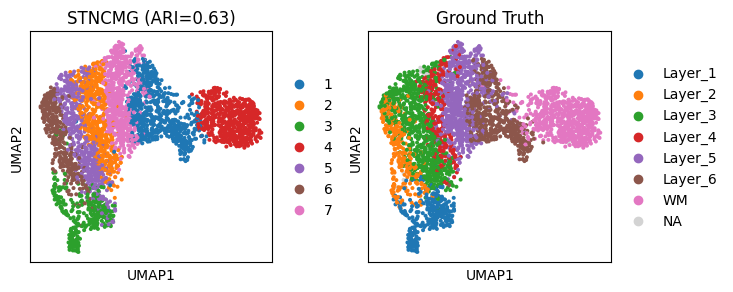

In [9]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STNCMG (ARI=%.2f)'%ARI, "Ground Truth"])

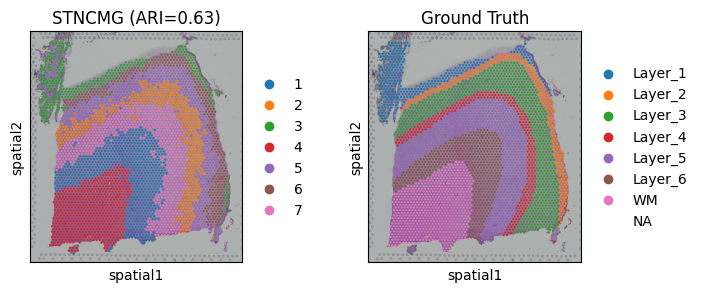

In [10]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STNCMG (ARI=%.2f)'%ARI, "Ground Truth"])